# Profiling report

This notebook processes the profiling records that were generated by `$REPO_ROOT/profiler.sh`,
computes aggregate statistics
and generates plots to be used for further analysis.

Results are exported to `$REPO_ROOT/reports/nb`.

---

Log

- 23/11/2023: 
    - Updating to multi-actor profiling reports
    - Set global plot config (cfr. `sns.set_context`)

---


In [291]:
import os
import json
import git
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import datetime
from scipy import stats
PARENT_DIR_REPORTS = './reports/nb/'
REPORT_TIMESTAMP = datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
DIR_REPORT = os.path.join(PARENT_DIR_REPORTS, REPORT_TIMESTAMP)
os.makedirs(DIR_REPORT, exist_ok=True)
DIR_REPORT

'./reports/nb/2023-11-23T18:51:08'

Plot config

In [292]:
sns.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":8})   

---

In [293]:
def get_repo_info():    
    repo = git.Repo(path='.')
    return {
        'head': repo.head.commit.__str__(),
        'branch': repo.active_branch.__str__()
    }


## Input data

In [294]:
records = dict(
    map(
        lambda fpath: (fpath, pd.Series(json.loads(open(fpath, 'r').read()), name=fpath)),
        glob('./reports/profiling/*.json')
    )
)
len(records)

256

In [295]:
series = pd.concat(records)
series.index.get_level_values(0).unique().shape
df = series.unstack()
df.index.set_names('fpath',inplace=True)
df.reset_index(inplace=True)
df['actor'] = df.fpath.apply(os.path.basename).str.split('-').apply(lambda x: x[0])
df.index.set_names('idx_report',inplace=True)
df.rename({'start':'start_report','end':'end_report','delta':'delta_report'},axis=1,inplace=True)
display(df.head())
df.shape

,fpath,start_report,end_report,delta_report,records,actor
idx_report,,,,,,
0,./reports/profiling/multiactor-report-17007615...,1700761587055,1700761588346,1291,"[{'index': 0, 'name': 'createDiplomaCredential...",multiactor
1,./reports/profiling/multiactor-report-17007616...,1700761670342,1700761672899,2557,"[{'index': 0, 'name': 'createDiplomaCredential...",multiactor
2,./reports/profiling/multiactor-report-17007615...,1700761501887,1700761503289,1402,"[{'index': 0, 'name': 'createDiplomaCredential...",multiactor
3,./reports/profiling/multiactor-report-17007589...,1700758933208,1700758934511,1303,"[{'index': 0, 'name': 'createDiplomaCredential...",multiactor
4,./reports/profiling/multiactor-report-17007571...,1700757104685,1700757105939,1254,"[{'index': 0, 'name': 'createDiplomaCredential...",multiactor


(256, 6)

## Analysis

In [296]:
AGG_FUNCTIONS = ['median','mean', 'std', 'min','max','count',pd.Series.skew, pd.Series.kurt]

---

### Task-level statistics

In [297]:
# Expand report records into task-level dataframes
df_tl = df.records\
    .apply(pd.Series)\
    .stack()\
    .apply(pd.Series)\
    .rename({'index':'idx_step', 'tag': 'actorTag', 'name': 'stepName', },axis=1)\
    .reset_index().drop('level_1',axis=1)\
    .set_index(['idx_report','idx_step'])
# Merge task-level df with initial df
df_tl = df.drop('records',axis=1).merge(df_tl,left_index=True,right_index=True)
df_tl['actorStep'] = df_tl.apply(lambda r: f'{r.actorTag}.{r.stepName}',axis=1)

# Add phases
phase_steps = {
    'pre-evaluation': [
        'university.createDiplomaCredential',
        'university.signDiplomaCredential',
        'government.createIdentityCredential',
        'government.signIdentityCredential',
    ],
     'phase-1': [
        'alice.deriveDiplomaCredential',
        'alice.createPresentation01',
        'alice.signPresentation01',
        'recruiter.verifyPresentation01'
    ],
    'phase-2': [
        'alice.deriveIdentityCredential',
        'alice.createPresentation02',
        'alice.signPresentation02',
        'recruiter.verifyPresentation02'
    ],
}
df_phase_steps = pd.Series(phase_steps)\
    .apply(pd.Series)\
    .stack()\
    .to_frame('actorStep')\
    .reset_index()\
    .drop('level_1',axis=1)\
    .rename({'level_0': 'phase'}, axis=1)

# sanity check: make sure that actorSteps exactly match
x = set(df_tl.actorStep.value_counts(dropna=False).index)
y = set(df_phase_steps.actorStep.value_counts().index)
assert len(x-y) == 0
df_phase_steps.head(3)

# merge df with phases back to df_tl
df_tl = df_tl.reset_index().merge(df_phase_steps, on='actorStep')
df_tl.set_index(['idx_report','idx_step'],inplace=True)

df_tl.to_csv(os.path.join(DIR_REPORT, 'df_task-level.csv'))

In [298]:
display(df_tl.head(3))
df_tl.shape

,,fpath,start_report,end_report,delta_report,actor,stepName,start,end,delta,actorTag,className,actorStep,phase
idx_report,idx_step,,,,,,,,,,,,,
0,0,./reports/profiling/multiactor-report-17007615...,1700761587055,1700761588346,1291,multiactor,createDiplomaCredential,1700761587055,1700761587056,1,university,DidVCActor,university.createDiplomaCredential,pre-evaluation
1,0,./reports/profiling/multiactor-report-17007616...,1700761670342,1700761672899,2557,multiactor,createDiplomaCredential,1700761670342,1700761670342,0,university,DidVCActor,university.createDiplomaCredential,pre-evaluation
2,0,./reports/profiling/multiactor-report-17007615...,1700761501887,1700761503289,1402,multiactor,createDiplomaCredential,1700761501887,1700761501887,0,university,DidVCActor,university.createDiplomaCredential,pre-evaluation


(3072, 13)

In [299]:
# df_stepname_order is used to specify the order of plots
df_stepname_order = df_tl.reset_index()[['idx_step','stepName','actorTag','actorStep','phase']].drop_duplicates()
df_stepname_order

,idx_step,stepName,actorTag,actorStep,phase
0,0,createDiplomaCredential,university,university.createDiplomaCredential,pre-evaluation
256,1,signDiplomaCredential,university,university.signDiplomaCredential,pre-evaluation
512,2,createIdentityCredential,government,government.createIdentityCredential,pre-evaluation
768,3,signIdentityCredential,government,government.signIdentityCredential,pre-evaluation
1024,4,deriveDiplomaCredential,alice,alice.deriveDiplomaCredential,phase-1
1280,5,createPresentation01,alice,alice.createPresentation01,phase-1
1536,6,signPresentation01,alice,alice.signPresentation01,phase-1
1792,7,verifyPresentation01,recruiter,recruiter.verifyPresentation01,phase-1
2048,8,deriveIdentityCredential,alice,alice.deriveIdentityCredential,phase-2
2304,9,createPresentation02,alice,alice.createPresentation02,phase-2


In [300]:
kwargs_violinplot = dict(
    x='delta',
    y='actorStep',
    hue='className'
)

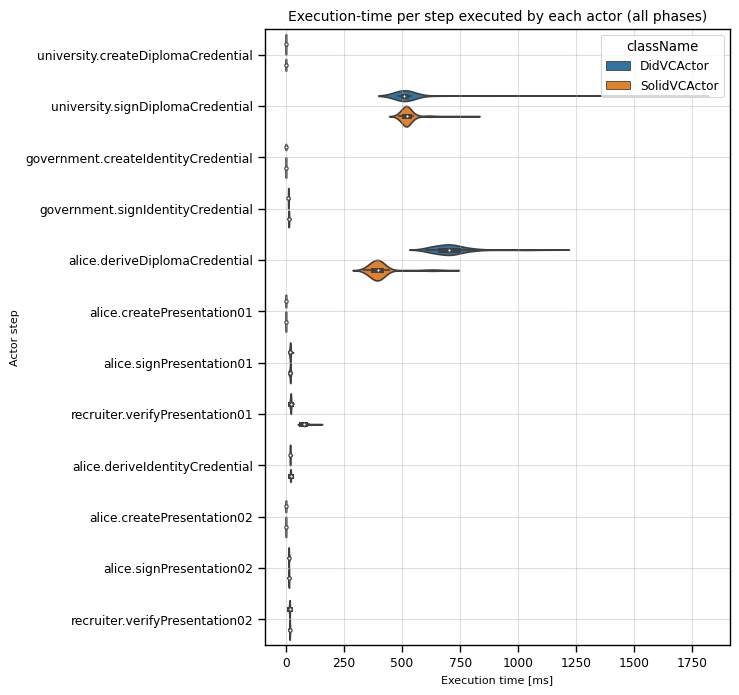

In [301]:
f, ax = plt.subplots(1,1, figsize=(6,8))
title = 'Execution-time per step executed by each actor (all phases)'
ax = sns.violinplot(df_tl,
                    **kwargs_violinplot,
                    order=df_stepname_order['actorStep'],
                    tight_layout=True,
                    ax=ax)
ax.set_title(title)
ax.set_ylabel('Actor step')
ax.set_xlabel('Execution time [ms]')
ax.grid(alpha=.4)
g.add_legend()
plt.savefig(os.path.join(DIR_REPORT,'violonplot-execution-time-per-actor-step-all-phases.png'),pad_inches=.5)
plt.show()

In [302]:
df_stepname_order

,idx_step,stepName,actorTag,actorStep,phase
0,0,createDiplomaCredential,university,university.createDiplomaCredential,pre-evaluation
256,1,signDiplomaCredential,university,university.signDiplomaCredential,pre-evaluation
512,2,createIdentityCredential,government,government.createIdentityCredential,pre-evaluation
768,3,signIdentityCredential,government,government.signIdentityCredential,pre-evaluation
1024,4,deriveDiplomaCredential,alice,alice.deriveDiplomaCredential,phase-1
1280,5,createPresentation01,alice,alice.createPresentation01,phase-1
1536,6,signPresentation01,alice,alice.signPresentation01,phase-1
1792,7,verifyPresentation01,recruiter,recruiter.verifyPresentation01,phase-1
2048,8,deriveIdentityCredential,alice,alice.deriveIdentityCredential,phase-2
2304,9,createPresentation02,alice,alice.createPresentation02,phase-2


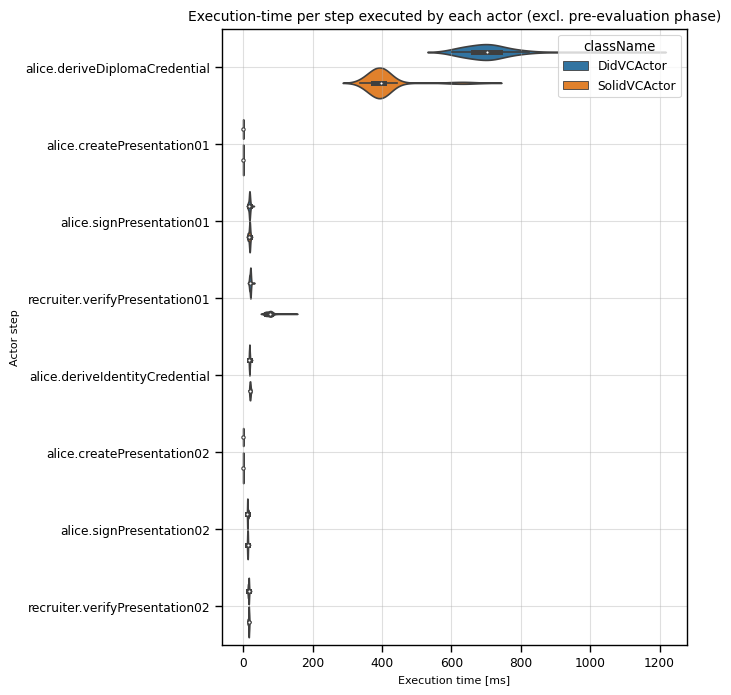

In [303]:
f, ax = plt.subplots(1,1, figsize=(6,8))
title = 'Execution-time per step executed by each actor (excl. pre-evaluation phase)'
snsdata = df_tl[df_tl.phase != 'pre-evaluation']
order_data = df_stepname_order[df_stepname_order.phase != 'pre-evaluation']['actorStep']
ax = sns.violinplot(snsdata,
                    **kwargs_violinplot,
                    order=order_data,
                    tight_layout=True,
                    ax=ax,
                   )
ax.set_title(title)
ax.set_ylabel('Actor step')
ax.set_xlabel('Execution time [ms]')
ax.grid(alpha=.4)
g.add_legend()
plt.savefig(os.path.join(DIR_REPORT,'violonplot-execution-time-per-actor-step-excl-pre-evaluation-phase.png'),pad_inches=.5)
plt.show()

In [304]:
snsdata = df_tl[df_tl.phase != 'pre-evaluation']

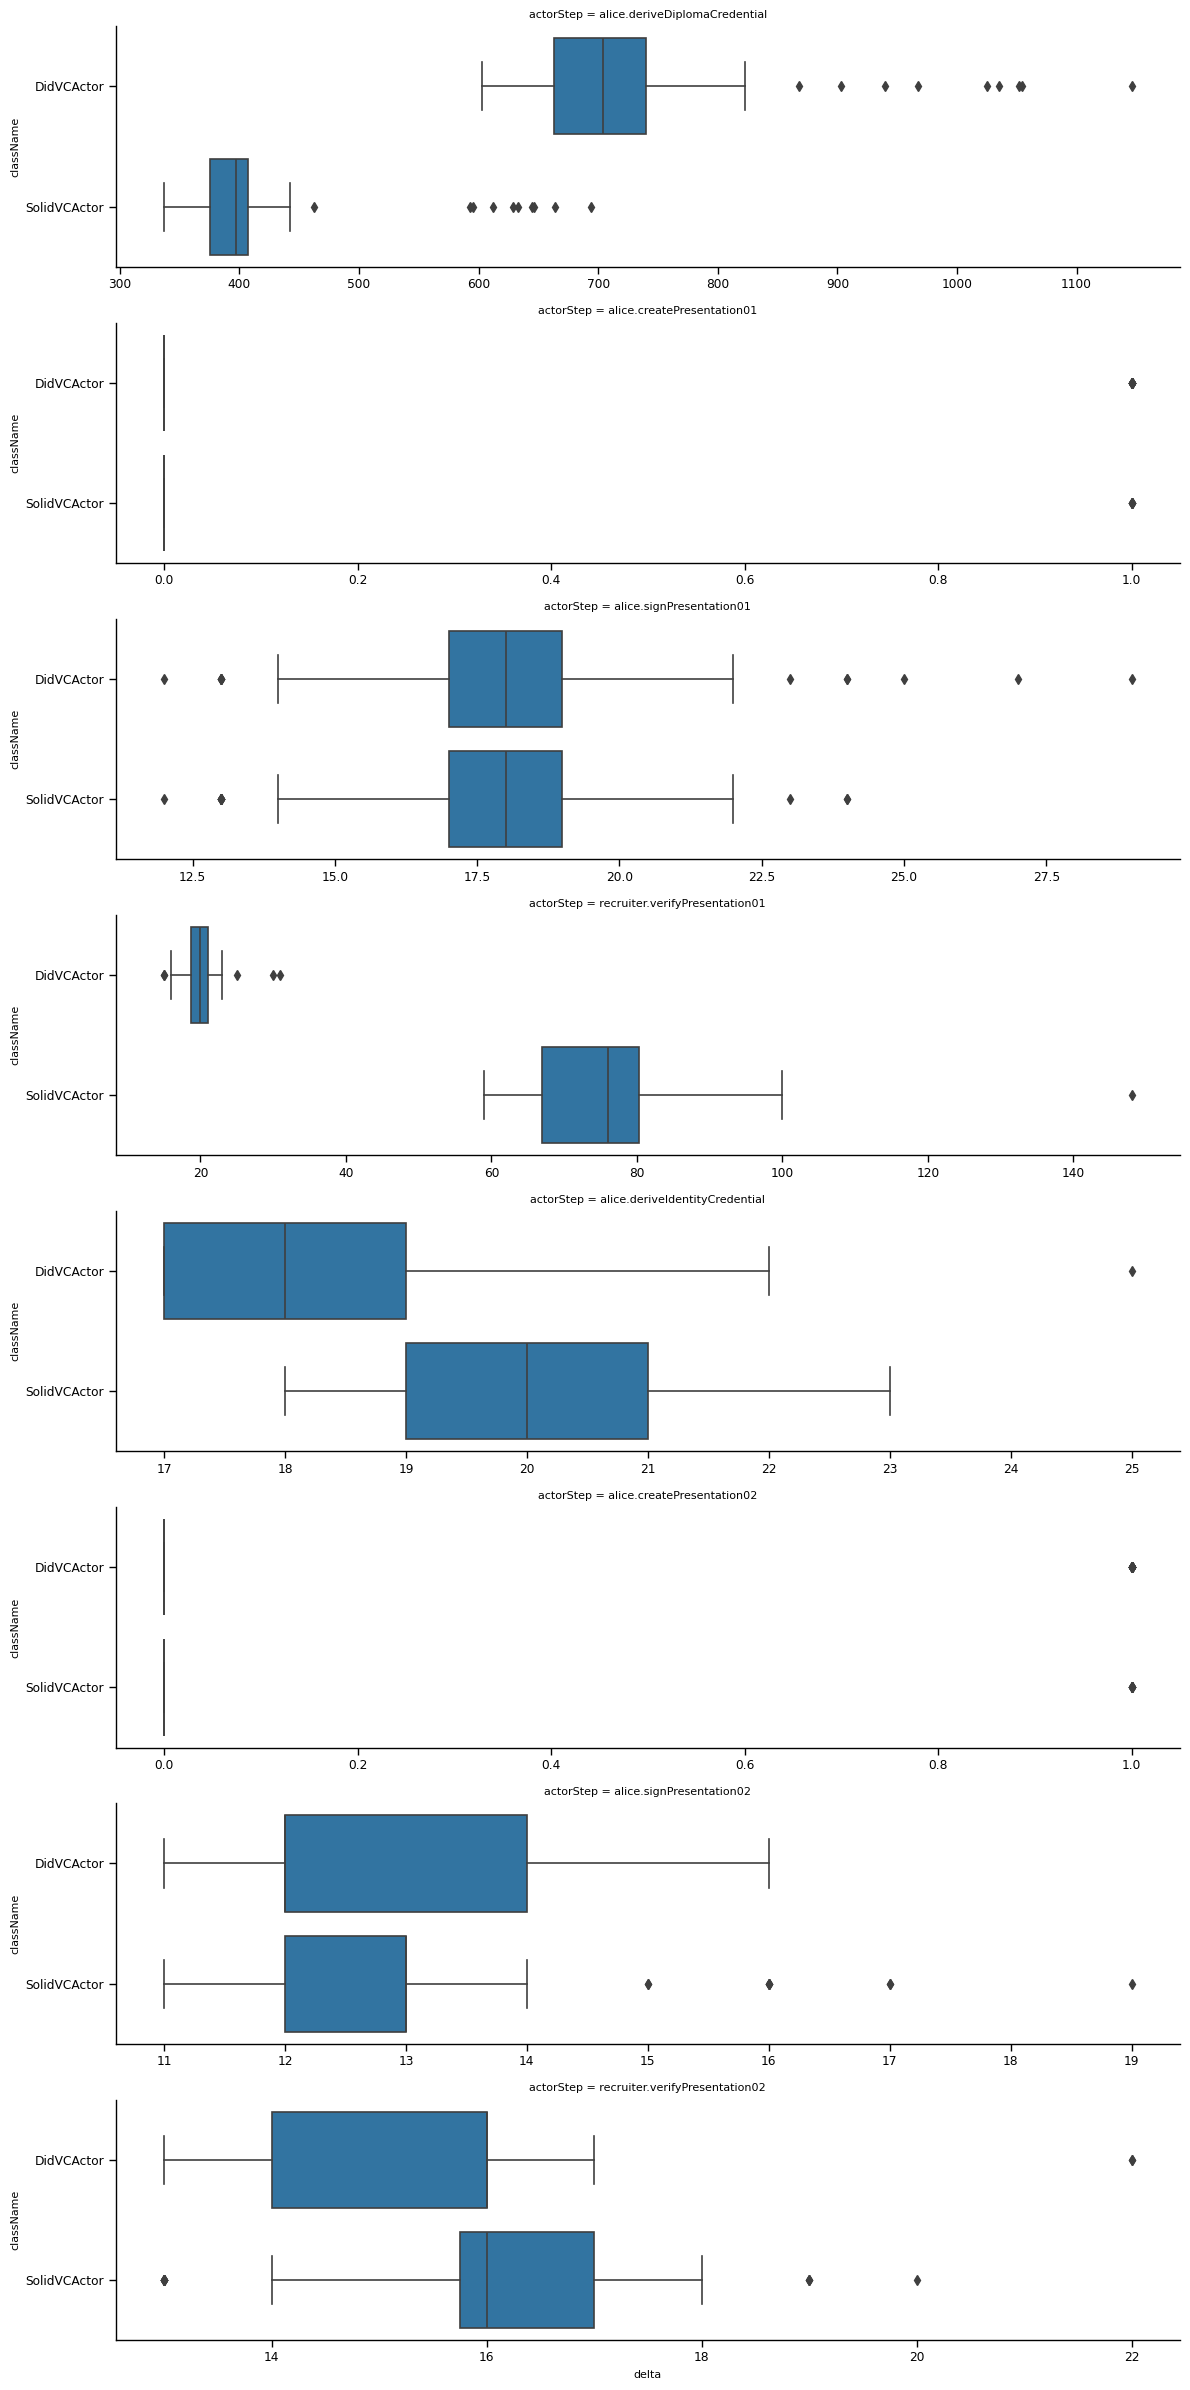

In [305]:
g = sns.FacetGrid(snsdata,col='actorStep',col_wrap=1, sharex=False, sharey=False, aspect=4)
g.map_dataframe(sns.boxplot, x='delta', y='className')

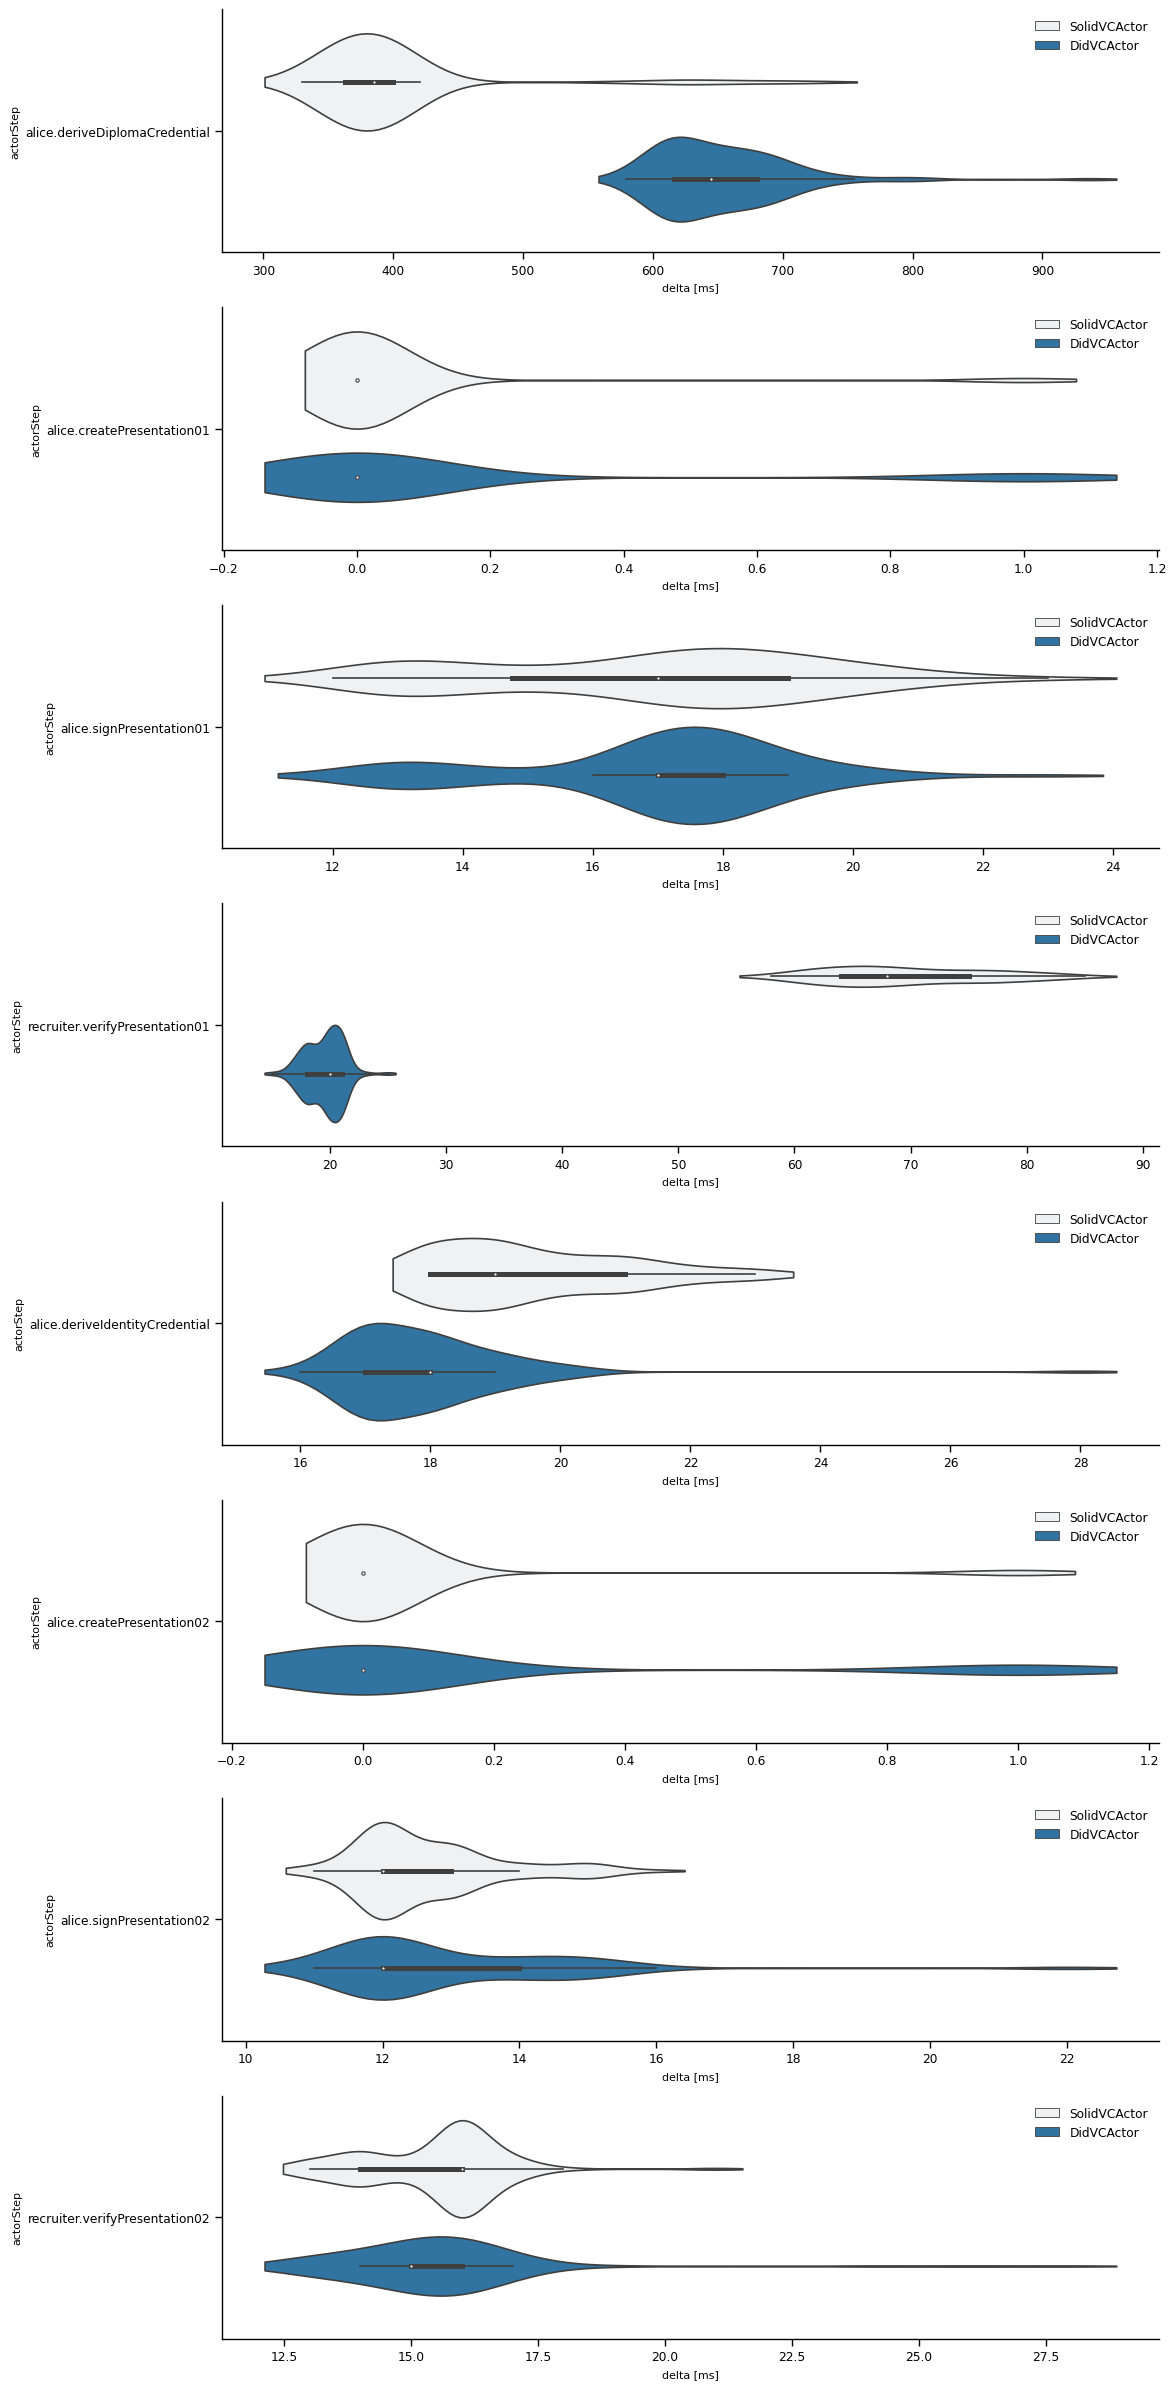

In [275]:
snsdata = df_tl[df_tl.phase != 'pre-evaluation']
g = sns.FacetGrid(snsdata,col='actorStep',col_wrap=1, sharex=False, sharey=False, aspect=4)
g.map_dataframe(sns.violinplot,
                **kwargs_violinplot,
                #inner='point',
                #inner='quart',
#                split='quart',
                cut=1,
                inner_kws=dict(box_width=15, whis_width=2, color=".8")

                
               )
# Create main legend
g.add_legend()
for ax in g.axes.ravel():
    ax.set_xlabel('{} [ms]'.format(kwargs_plot['x']))
    ax.set_title('')
    # Add a copy of the main legend to each subplot
    ax.legend(handles=g.legend.legend_handles,frameon=False)

# Hide main legend
g.legend.set_visible(False)
g.tight_layout()
plt.show()

Compute & export aggregate statistics

In [306]:
# name refers to the function/step name
df_tl_agg = df_tl.groupby(['actorTag','className','stepName'])['delta'].agg(AGG_FUNCTIONS)
df_tl_agg.to_csv(os.path.join(DIR_REPORT, 'df_agg_task-level.csv'))
df_tl_agg.shape

(24, 8)

In [307]:
df_tl_agg.unstack('className').swaplevel(0,1,axis=1).sort_index(axis=1)

className                           DidVCActor                                \
                                         count        kurt   max        mean   
actorTag   stepName                                                            
alice      createPresentation01            128    4.485484     1    0.109375   
           createPresentation02            128    1.391787     1    0.164062   
           deriveDiplomaCredential         128    5.829249  1146  718.437500   
           deriveIdentityCredential        128    7.871675    25   18.203125   
           signPresentation01              128    3.073486    29   18.023438   
           signPresentation02              128   -0.256710    16   12.828125   
government createIdentityCredential        128   15.777313     3    0.156250   
           signIdentityCredential          128    0.714529    14   10.726562   
recruiter  verifyPresentation01            128    6.348600    31   20.140625   
           verifyPresentation02            128    5.783429    22   15.421875   
university createDiplomaCredential         128    6.050400     1    0.093750   
           signDiplomaCredential           128  102.405605  1733  524.968750   

className                                                              \
                                    median  min      skew         std   
actorTag   stepName                                                     
alice      createPresentation01        0.0    0  2.532911    0.313335   
           createPresentation02        0.0    0  1.835833    0.371787   
           deriveDiplomaCredential   704.0  603  2.160319   95.042282   
           deriveIdentityCredential   18.0   17  2.172297    1.219006   
           signPresentation01         18.0   12  0.821891    2.609688   
           signPresentation02         12.0   11  0.977997    1.274272   
government createIdentityCredential    0.0    0  3.431063    0.424403   
           signIdentityCredential     10.0    9  1.128166    1.062717   
recruiter  verifyPresentation01       20.0   15  1.255721    2.219223   
           verifyPresentation02       16.0   13  1.227128    1.412037   
university createDiplomaCredential     0.0    0  2.820655    0.292626   
           signDiplomaCredential     510.0  484  9.786593  113.795295   

className                           SolidVCActor                              \
                                           count       kurt  max        mean   
actorTag   stepName                                                            
alice      createPresentation01              128  17.089316    1    0.046875   
           createPresentation02              128  11.559822    1    0.062500   
           deriveDiplomaCredential           128   8.216168  694  408.382812   
           deriveIdentityCredential          128  -0.242648   23   19.882812   
           signPresentation01                128   0.325645   24   17.882812   
           signPresentation02                128   7.334008   19   12.843750   
government createIdentityCredential          128  39.253853    1    0.023438   
           signIdentityCredential            128  11.444345   19   12.437500   
recruiter  verifyPresentation01              128  14.557400  148   75.304688   
           verifyPresentation02              128   1.114128   20   15.898438   
university createDiplomaCredential           128  10.836529    3    0.195312   
           signDiplomaCredential             128  17.249721  802  527.945312   

className                                                             
                                    median  min      skew        std  
actorTag   stepName                                                   
alice      createPresentation01        0.0    0  4.338491   0.212202  
           createPresentation02        0.0    0  3.657789   0.243013  
           deriveDiplomaCredential   397.0  337  2.924543  66.309359  
           deriveIdentityCredential   20.0   18  0.548566   1.372515  
     

In [308]:
df_tl_agg.unstack('className').swaplevel(0,1,axis=1).sort_index(axis=1).filter(regex='median|mean').round(2)

className                           DidVCActor        SolidVCActor       
                                          mean median         mean median
actorTag   stepName                                                      
alice      createPresentation01           0.11    0.0         0.05    0.0
           createPresentation02           0.16    0.0         0.06    0.0
           deriveDiplomaCredential      718.44  704.0       408.38  397.0
           deriveIdentityCredential      18.20   18.0        19.88   20.0
           signPresentation01            18.02   18.0        17.88   18.0
           signPresentation02            12.83   12.0        12.84   13.0
government createIdentityCredential       0.16    0.0         0.02    0.0
           signIdentityCredential        10.73   10.0        12.44   12.0
recruiter  verifyPresentation01          20.14   20.0        75.30   76.0
           verifyPresentation02          15.42   16.0        15.90   16.0
university createDiplomaCredential        0.09    0.0         0.20    0.0
           signDiplomaCredential        524.97  510.0       527.95  520.5

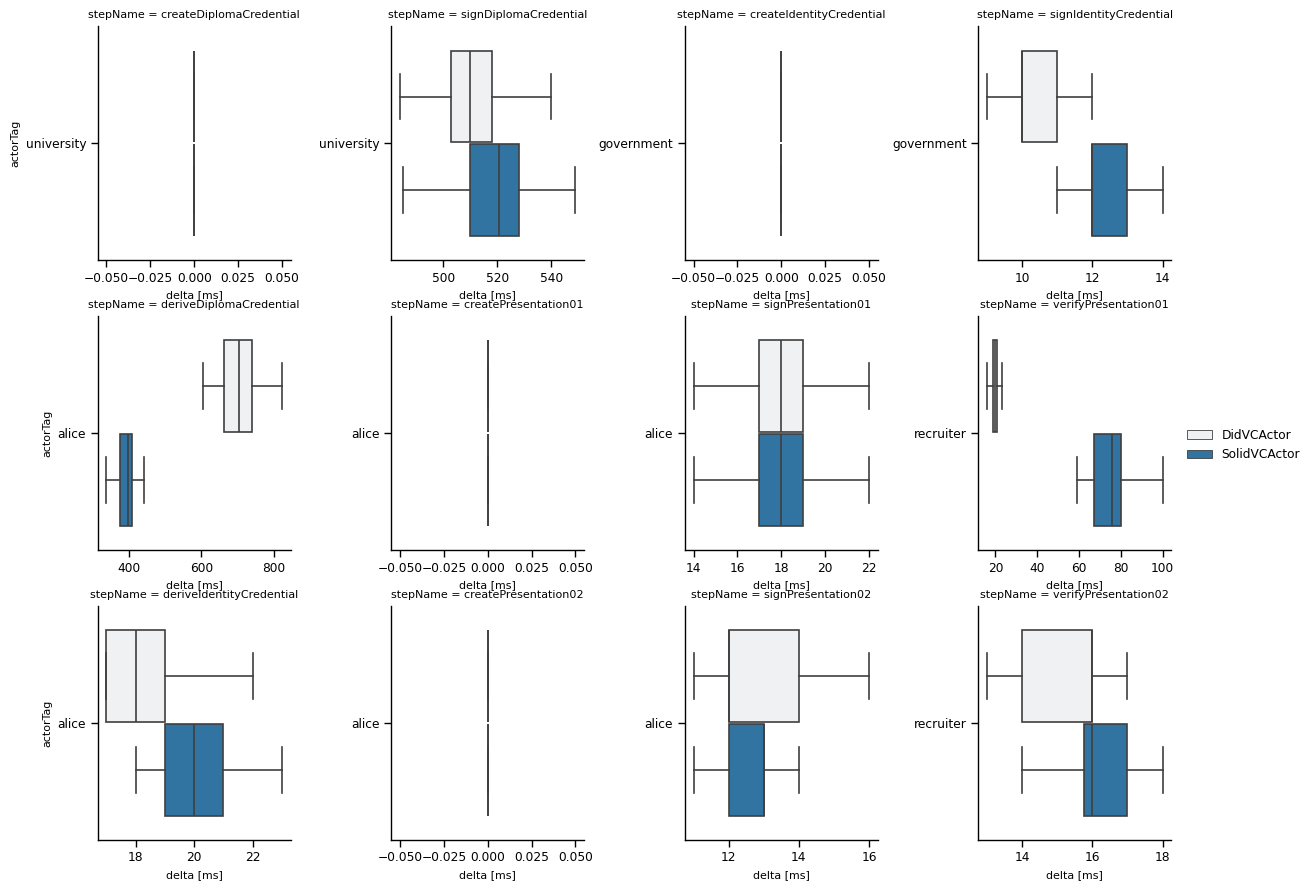

In [309]:
kwargs_fg = dict(col = 'stepName',  col_wrap=4, sharey=False,sharex=False,aspect=1)
kwargs_plot = dict(
    x='delta',
    y='actorTag',
    hue='className',
    orient='h',
    showfliers=False,
)
g = sns.FacetGrid(**kwargs_fg, data=df_tl)
g.map_dataframe(sns.boxplot, **kwargs_plot)

for ax in g.axes.ravel():
    ax.set_xlabel('{} [ms]'.format(kwargs_plot['x']))
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    pass
g.add_legend()
plt.savefig(os.path.join(DIR_REPORT,'boxplot-actor-on-delta-per-step.png'),pad_inches=.5)
plt.show()

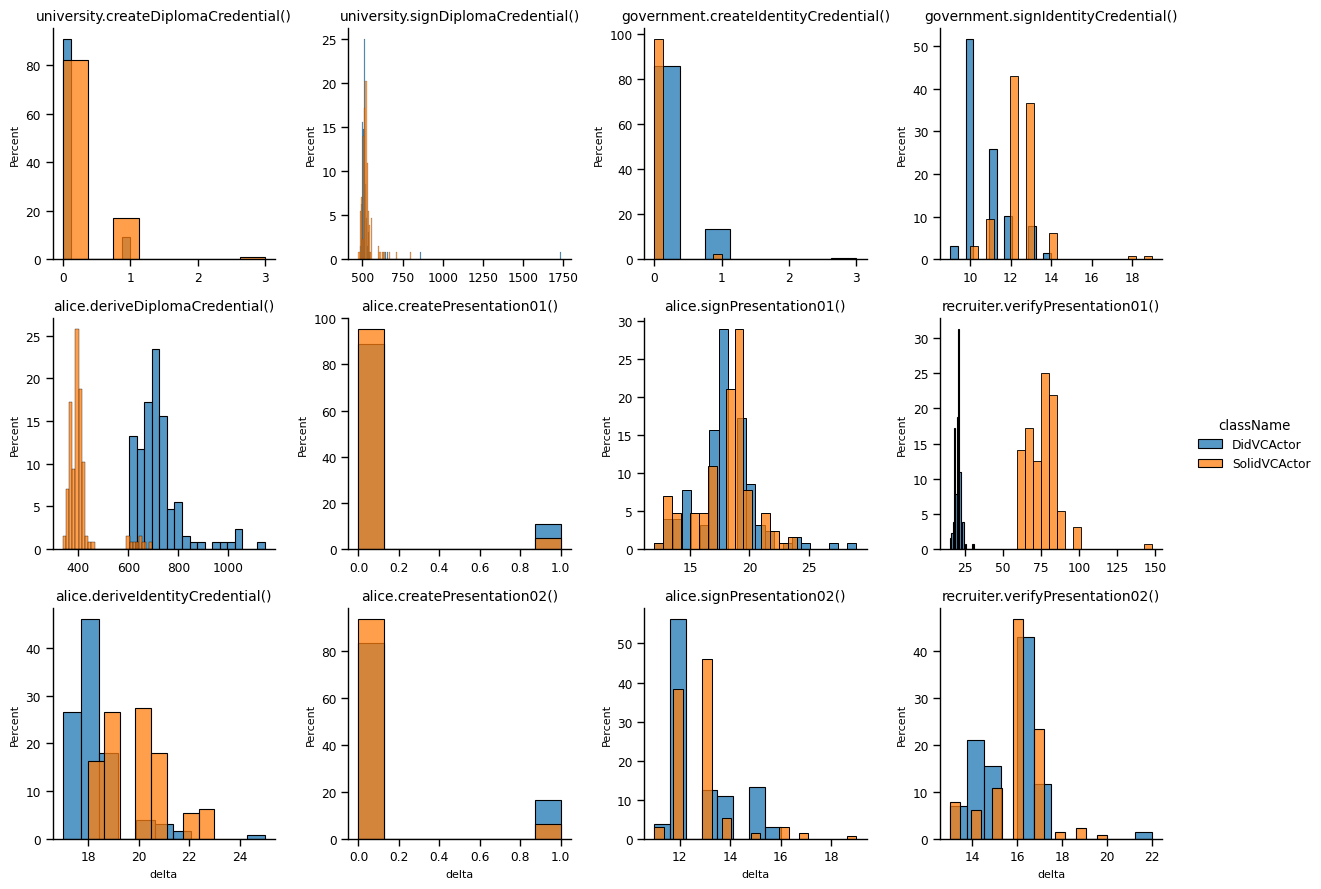

In [310]:
kwargs_fg = dict(col = 'stepName',
                 hue='className',
                 col_wrap=4,
                 sharey=False,
                 sharex=False,
                 legend_out=True,
                 col_order = df_stepname_order['stepName']
)
kwargs_plot = dict(
    x='delta',
    stat='percent',
    element='bars',
    discrete=False,
)

g = sns.FacetGrid(**kwargs_fg, data=df_tl)
g = g.map_dataframe(sns.histplot, **kwargs_plot)
for ax in g.axes.ravel():
    pass

for i, r in df_stepname_order.iterrows():
    ax_i = g.axes_dict[r.stepName]
    ax_i.set_title(f'{r.actorTag}.{r.stepName}()')


g.add_legend()
g.tight_layout()
plt.savefig(os.path.join(DIR_REPORT,'barplot-actor-on-percentage-delta-per-step.png'))
plt.show()

In [54]:
get_repo_info()
json.dump(get_repo_info(), open(os.path.join(DIR_REPORT,'repo-info.json'), 'w'))

---

ALL CELLS BELOW NEED TO UPDATED.</br>
The profiling data model changed while transitioning to multiactor profiling :) .

---

## Statistics

### Significance testing

- H0: There is no significant difference in performance between the two software implementations.
- H1: There is a significant difference in performance between the two software implementations.

In [15]:
p_thresh = .05

In [16]:
steps = df_tl.stepName.unique()
print(steps)

['createDiplomaCredential' 'signDiplomaCredential'
 'createIdentityCredential' 'signIdentityCredential'
 'deriveDiplomaCredential' 'createPresentation01' 'signPresentation01'
 'verifyPresentation01' 'deriveIdentityCredential' 'createPresentation02'
 'signPresentation02' 'verifyPresentation02']


In [17]:
grpr_className = df_tl.groupby('className')
assert grpr_className.ngroups == 2
A,B = grpr_className

Reminder

- H0: There is no significant difference in performance between the two software implementations.
- H1: There is a significant difference in performance between the two software implementations.

In [18]:
_var = 'delta'
ttr_ind_per_step = {}
# destructure group key and group dfs
k_a, df_a = A
k_b, df_b = B

print(f'''
    Group A: {k_a}
    Group B: {k_b}
    Tested variable: {_var}
''')
for step_name in steps:
        a = df_a[df_a.stepName == step_name][_var].values.tolist()
        b = df_b[df_b.stepName == step_name][_var].values.tolist()
        assert np.shape(a) == np.shape(b)
        ttr_ind_per_step[step_name]=stats.ttest_ind(a,b)
        
df_test_results = pd.Series(ttr_ind_per_step).apply(lambda t: t._asdict()).apply(pd.Series)
df_test_results.rename({'statistic': 'tvalue'}, axis=1,inplace=True)
# Add flag to indicate whether to accept/reject H0
df_test_results['REJECT_H0'] = df_test_results.pvalue < p_thresh
df_test_results['Conclusion'] = df_test_results.REJECT_H0.apply(lambda reject_H0: 
                                                                f'Significant difference in "{_var}" between {k_a} and {k_b}' if reject_H0
                                                                else f'No significant difference in "{_var}" between {k_a} and {k_b}' 
                                                               )
df_test_results


    Group A: DidVCActor
    Group B: SolidVCActor
    Tested variable: delta



,tvalue,pvalue,df,_alternative,_standard_error,_estimate,REJECT_H0,Conclusion
createDiplomaCredential,-2.737132,6.761936e-03,198.0,0.0,0.051148,-0.14,True,"Significant difference in ""delta"" between DidV..."
signDiplomaCredential,-3.455006,6.731413e-04,198.0,0.0,5.881322,-20.32,True,"Significant difference in ""delta"" between DidV..."
createIdentityCredential,1.443680,1.504095e-01,198.0,0.0,0.027707,0.04,False,"No significant difference in ""delta"" between D..."
signIdentityCredential,-7.824610,2.989475e-13,198.0,0.0,0.190425,-1.49,True,"Significant difference in ""delta"" between DidV..."
deriveDiplomaCredential,28.343492,1.294387e-71,198.0,0.0,8.972783,254.32,True,"Significant difference in ""delta"" between DidV..."
createPresentation01,2.496849,1.334581e-02,198.0,0.0,0.040050,0.10,True,"Significant difference in ""delta"" between DidV..."
signPresentation01,0.295484,7.679338e-01,198.0,0.0,0.338428,0.10,False,"No significant difference in ""delta"" between D..."
verifyPresentation01,-71.315470,3.619491e-143,198.0,0.0,0.703634,-50.18,True,"Significant difference in ""delta"" between DidV..."
deriveIdentityCredential,-8.252827,2.146932e-14,198.0,0.0,0.201143,-1.66,True,"Significant difference in ""delta"" between DidV..."
createPresentation02,2.749337,6.524234e-03,198.0,0.0,0.043647,0.12,True,"Significant difference in ""delta"" between DidV..."


In [19]:
steps_with_sig_diff = df_test_results[df_test_results.REJECT_H0].index
print(steps_with_sig_diff)

Index(['createDiplomaCredential', 'signDiplomaCredential',
       'signIdentityCredential', 'deriveDiplomaCredential',
       'createPresentation01', 'verifyPresentation01',
       'deriveIdentityCredential', 'createPresentation02'],
      dtype='object')


In [20]:
df_tl_sig_diff = df_tl[df_tl.stepName.apply(lambda n: n in steps_with_sig_diff)]
df_tl_sig_diff.shape

(1600, 11)

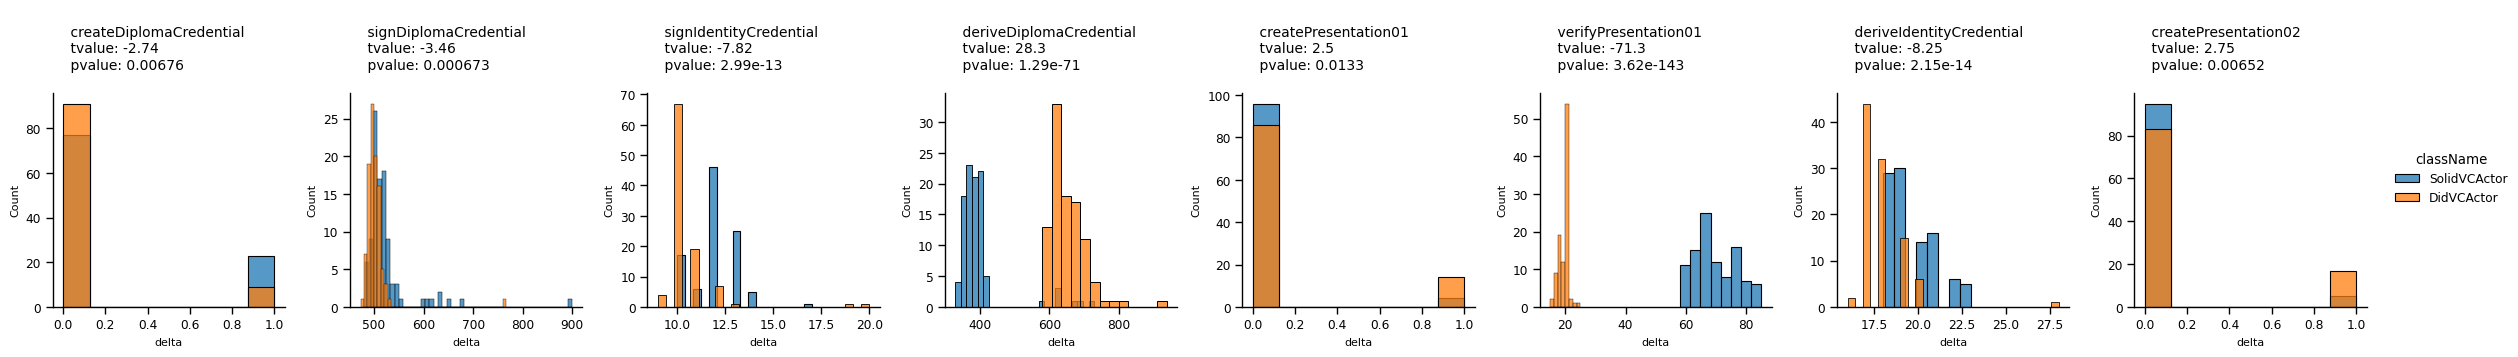

In [21]:
g = sns.FacetGrid(df_tl_sig_diff,col='stepName',legend_out=True, hue='className',sharex=False, sharey=False)

g = g.map_dataframe(sns.histplot, x='delta',)
g.add_legend()

for c in g.col_names:
    s = df_test_results.loc[c]

    g.axes_dict[c].set_title('',loc='center')
    txt_stats = f'''
    {c}
    tvalue: {s["tvalue"]:.3}
    pvalue: {s["pvalue"]:.3}
    '''
    g.axes_dict[c].set_title(txt_stats,loc='left')

### Effect size

#### Cohen's d

$$
d = \frac{\bar x_1 - \bar x_2}{s}
$$

|Effect size|	d|
|-----------|----|
|Very small	|0.01|
|Small		|0.20|
|Medium		|0.50|
|Large		|0.80|
|Very large	|1.20|
|Huge		|2.00|


> A positive d indicates that the first mean is higher. In contrast, a negative d indicates that the second mean is higher. In terms of size, Cohen suggested that a d of 0.2 represents a small effect, 0.5 a medium effect, and 0.8 or higher a large effect. However, these are guidelines rather than strict rules.

In [22]:
from numpy import var, mean, sqrt

def cohend(d1: pd.Series, d2: pd.Series) -> float:

    # calculate the size of samples
    n1, n2 = len(d1), len(d2)

    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)

    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))

    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)

    # return the effect size
    return (u1 - u2) / s

In [23]:
_var = 'delta'
effect_size_per_step = {}
# destructure group key and group dfs
k_a, df_a = A
k_b, df_b = B

for step_name in steps:
        a = df_a[df_a.stepName == step_name][_var]
        b = df_b[df_b.stepName == step_name][_var]
        effect_size_per_step[step_name] = cohend(a,b)
        
s_effect_sizes = pd.Series(effect_size_per_step, name=f'cohend_{k_a}_{k_b}')

df_effect_sizes = s_effect_sizes.to_frame()
def cohend_effect_class(d: float) -> str:
    d = np.abs(d)
    if d >= 2.0:
        return 'HUGE'
    if d >= 1.2:
        return 'VERY_LARGE'
    if d >= 0.8:
        return 'LARGE'
    if d >= 0.5:
        return 'MEDIUM'
    if d >= 0.2:
        return 'SMALL'
    if d > 0.01:
        return 'VERY_SMALL'
    return 'NIHIL'

df_effect_sizes['effect_class'] = s_effect_sizes.apply(cohend_effect_class)
df_effect_sizes

,cohend_DidVCActor_SolidVCActor,effect_class
createDiplomaCredential,-0.387089,SMALL
signDiplomaCredential,-0.488612,SMALL
createIdentityCredential,0.204167,SMALL
signIdentityCredential,-1.106567,LARGE
deriveDiplomaCredential,4.008375,HUGE
createPresentation01,0.353108,SMALL
signPresentation01,0.041788,VERY_SMALL
verifyPresentation01,-10.085531,HUGE
deriveIdentityCredential,-1.167126,LARGE
createPresentation02,0.388815,SMALL


In [24]:
df_effect_sizes.to_csv(os.path.join(DIR_REPORT, 'df_effect_sizes.csv'))

# Appendix

## Statsmodels

In [25]:
?stats.ttest_ind

Signature:
stats.ttest_ind(
    a,
    b,
    axis=0,
    equal_var=True,
    nan_policy='propagate',
    permutations=None,
    random_state=None,
    alternative='two-sided',
    trim=0,
    *,
    keepdims=False,
)
Docstring:
Calculate the T-test for the means of *two independent* samples of scores.

This is a test for the null hypothesis that 2 independent samples
have identical average (expected) values. This test assumes that the
populations have identical variances by default.

Parameters
----------
a, b : array_like
    The arrays must have the same shape, except in the dimension
    corresponding to `axis` (the first, by default).
axis : int or None, default: 0
    If an int, the axis of the input along which to compute the statistic.
    The statistic of each axis-slice (e.g. row) of the input will appear in a
    corresponding element of the output.
    If ``None``, the input will be raveled before computing the statistic.
equal_var : bool, optional
    If True (default), pe